## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
len(df.query('converted == 1')) / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
len(df.query('(group == "control" and landing_page == "new_page") or (group == "treatment" and landing_page == "old_page")'))

3893

f. Do any of the rows have missing values?

>No

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [7]:
df_to_drop = df.query('(group == "control" and landing_page == "new_page") or (group == "treatment" and landing_page == "old_page")')
df2 = df.drop(df_to_drop.index, axis=0)

In [8]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [9]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [10]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

See above

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [11]:
df2.drop_duplicates(subset='user_id', inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
p_converted = len(df2.query('converted == 1')) / len(df2)
p_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
p_control_converted = len(df2.query('converted == 1 and group == "control"')) / len(df2.query('group == "control"'))
p_control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
p_treatment_converted = len(df2.query('converted == 1 and group == "treatment"')) / len(df2.query('group == "treatment"'))
p_treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [16]:
p_new_page = len(df2.query('landing_page == "new_page"')) / len(df2)
p_new_page

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>I think there is insufficient evidence to conclude the new treatment page leads to more conversions because the probabilities that they are converted given that they are in the control group or in the treatment group are almost the same, close to 12%.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

>$$H_0: p_{new} - p_{old} \leq 0$$
>$$H_1: p_{new} - p_{old} > 0$$
>
>where $p_{old}$ and $p_{new}$ are the converted success rates of the new webpage and old webpage respectively.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [17]:
p_new = len(df.query('converted == 1')) / len(df)

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [18]:
p_old = len(df.query('converted == 1')) / len(df)

c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [20]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.choice(2, n_new, replace=True, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.choice(2, n_old, replace=True, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
new_page_converted.mean() - old_page_converted.mean()

-0.0023630295335728135

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
p_diffs = []
for i in range(10000):
    np_converted = np.random.choice(2, n_new, replace=True, p=[1-p_new, p_new])
    op_converted = np.random.choice(2, n_old, replace=True, p=[1-p_old, p_old])
    p_diffs.append(np_converted.mean() - op_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

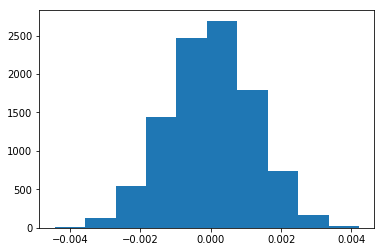

In [25]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [26]:
obs_diff = p_treatment_converted - p_control_converted
(p_diffs > obs_diff).mean()

0.90100000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>The value calculated in part j. is the probability that values more extreme than the observed difference are observed in random variations under the null hypothesis. For scientific studies, this is called the p-value. The lower the p-value, the more likely the observed difference is a result of an actual difference as opposed to random variations in the null hypothesis. If it is lower than the alpha value that we choose when testing the hypothesis, we can reject the null hypothesis at a confidence interval corresponding to the alpha value.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [27]:
import statsmodels.api as sm

convert_old = len(df2.query('converted == 1 and landing_page == "old_page"'))
convert_new = len(df2.query('converted == 1 and landing_page == "new_page"'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [28]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>The z-score calculated is the number of standard deviations the new page conversion rate is away from the the old page conversion rate. In our case, the new page conversion rate is 1.31 standard deviations lower than the old page conversion rate. The p-value calculated is the probability that a value in the distribution of the old page conversion rate is lower than the new page conversion rate, which is 90.5%. This is the same value calculated in parts j. and k., so the results agree.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [29]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [30]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [31]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        03:06:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

>The p-value is 19.0%, which is different from the 90.5% value that was found in Part II. The difference is because the logistic regression model uses a two-tailed hypothesis test. The two-tailed test gives p-values for a null hypothesis where the difference in mean conversion is equal to zero, and an alternative where there is a difference in mean conversion in either directions, smaller or larger than zero. 

>In Part II, we defined the null hypothesis as the difference in mean conversion being less than or equal to zero, and an alternative where the difference in mean conversion is larger than zero. This is thus a right one-tailed hypothesis test. We have a difference in mean conversion that is less than zero because the old page has slightly better conversion than the new page. As a result, we have a large p-value over 50% because the result was the opposite of our alternate hypothesis. We can do the same statistical analysis with a left one-tailed hypothesis test to potentially obtain a lower p-value, although this may not be practically useful.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>It is a good idea to consider other factors because whether or not an individual converts is likely affected by multiple factors. Therefore, by including other factors, we may be able to arrive at a model that can better predict our response variable with less variability. Also, phenomenon such as the novelty effect or change aversion can influence the results. On the other hand, including other factors may introduction problems into our models such as correlated errors, non-constant variance, and multicollinearity. This can distort the analysis and produce unrealistic statistical parameters and results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [32]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [33]:
df2.set_index('user_id')
df3 = df2.join(df_countries.set_index('user_id'), on='user_id')

In [34]:
df3 = df3.join(pd.get_dummies(df3['country']))

In [35]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
res = lm.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:               2.323e-05
Time:                        03:06:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

>According to the model, CA has the lowest correlation with conversion, US is in the middle, and UK has the highest correlation. However, the country does not seem to have a statistically significant impact on conversion because of the large p-values of 13.0% and 45.7% respectively for CA and UK, using US as the baseline. There is also the possibility that we introduced errors into our model by adding more factors. For example, country and the web page may be related to one another, thus introducing multicollinearity effects. This would distort our model because multivariable regression assumes the explanatory variables are independent. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [36]:
df3['page_CA'] = df3['ab_page'] * df3['CA']
df3['page_UK'] = df3['ab_page'] * df3['UK']
df3['page_US'] = df3['ab_page'] * df3['US']

In [37]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'page_CA', 'page_UK']])
res = lm.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:               3.482e-05
Time:                        03:06:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

>From the model results, there does not seem to be a statistically significant effect between the interaction between page and country and the conversion. For the interaction between page and CA, the p-value is 38.3% and for the interaction between page and UK, the p-value is 76.0%. Furthermore, by including interaction terms, interpreting the coefficients and results becomes more difficult.

In this project, analysis of A/B test data for a new webpage and old webpage was performed to investigate which page had a higher conversion rate. The results of the data analysis and models showed that the old webpage had a better conversion rate than the new webpage. However, it was not statistically significant based on the p-values obtained. It was also found that country and interactions between the country and webpage did not have statistically significant results either based on a logistic regression model.

From the data analysis, it is recommended that the company should stay with the old webpage. Although the statistical significance was inconclusive, the old webpage had a higher mean conversion than the new webpage. Also, staying with the old webpage also avoids the risk of change aversion.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0